# Preprocessing

Импортируем библиотеки и прописываем пути, устанавливаем random_state.

In [1]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [2]:
PATH_COVERS = 'data/raw/covers.json'
PATH_LYRICS = 'data/raw/lyrics.json'
PATH_META = 'data/raw/meta.json'

RANDOM_STATE = 54321

Напишем функцию, которая на вход будет принимать пути к нашим датасетам, проводить чистку данных и возвращать объединённый датасет. Также будем использовать функцию написанную в EDA, для частичного восстановления языка.

In [3]:
def clear_text(correct_simb: str, text: str) -> str:
    new_text = re.sub(correct_simb, ' ', text)    
    new_text = new_text.split()
    return ' '.join(new_text)

In [4]:
def get_united_df(path_covers: str, psth_lyrics: str, path_meta: str) -> pd.DataFrame:
    df_covers = pd.read_json(PATH_COVERS, lines=True)
    df_lyrics = pd.read_json(PATH_LYRICS, lines=True)
    df_meta = pd.read_json(PATH_META, lines=True, convert_dates=['dttm'])
    
    df_covers = df_covers.dropna()
    df_lyrics = df_lyrics.drop_duplicates(subset='track_id')
    df_meta = df_meta[df_meta['duration']!=0]
    
    df_union = (df_covers.merge(df_lyrics, on = 'track_id', how = 'inner')
                     .merge(df_meta, on = 'track_id', how = 'inner'))
    
    df_union['clear_text'] = df_union['text'].apply(lambda x: clear_text(r'[^а-яА-Я]', x))
    df_union.loc[(df_union['clear_text'] != '') &
             (df_union['language'].isna()), 'language'] = 'RU' 
    df_union = df_union.drop('clear_text', axis=1)
    
    return df_union.dropna()

In [5]:
df_union = get_united_df(PATH_COVERS, PATH_LYRICS, PATH_META)
df_union.shape

(2823, 11)

У нас получился датасет из 2823 строк, в котором есть все требуемые данные.

Теперь нам нужно создать столбец в котором будут указаны все каверы / оригиналы для конкретного original_track_id и посчитать их количество

In [6]:
def make_covers_column(df: pd.DataFrame, count_cover=True) -> pd.DataFrame:
    df_new = df.copy(deep=True)
    df_group = df.groupby('original_track_id', as_index= False ).agg({'track_id': ' '. join})
    df_group = df_group.rename(columns = {'track_id': 'cover_list'})
    df_group['cover_list'] = df_group['cover_list'].str.split()
    
    # присоединим список с датасетом и удалим из списка сам трек
    df_new = df_new.merge(df_group, on = 'original_track_id', how='inner')
    df_new['cover_list'] = df_new.apply(lambda x: list(set(x['cover_list']) ^ {x['track_id']}), axis=1)
    
    if count_cover:
        df_new['cover_count'] = df_new['cover_list'].apply(lambda x: len(x))

    return df_new

In [7]:
df_union = make_covers_column(df_union)
df_union.head()

,original_track_id,track_id,track_remake_type,lyricId,text,dttm,title,language,isrc,genres,duration,cover_list,cover_count
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...,2009-11-11 21:00:00,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,"[b5f9882ee2f5ba91089e3fcaf47ed061, c99604698f8...",13
1,eeb69a3cb92300456b6a5f4162093851,14cd5aac84c43bf6830c8276c05ee2f8,COVER,dee9f62b6793743f535dc38c3dbd9424,Left a good job down in the city\nWorkin' for ...,2010-01-31 21:00:00,Proud Mary,EN,FRZ040600166,"[ROCK, ALLROCK]",395460.0,"[b5f9882ee2f5ba91089e3fcaf47ed061, c99604698f8...",13
2,eeb69a3cb92300456b6a5f4162093851,c99604698f81b2454389e8e3b6d3520b,COVER,d31d606bc0221f04551e2b04737bd24f,"You know, every now and then I think you might...",2014-04-16 20:00:00,Proud Mary,EN,GBAYE9300862,"[POP, RNB]",327390.0,"[b5f9882ee2f5ba91089e3fcaf47ed061, b9564f7c8ee...",13
3,eeb69a3cb92300456b6a5f4162093851,70ce45ec4414b7993d98718995456668,COVER,86390e840a3342d5c7431daca79d278e,"Y' know, Every now and then\nI think You might...",2012-12-29 22:56:50,Proud Mary,EN,FR6V81426499,"[ELECTRONICS, LOUNGE]",190030.0,"[b5f9882ee2f5ba91089e3fcaf47ed061, c99604698f8...",13
4,eeb69a3cb92300456b6a5f4162093851,e58d2c71ff16648513a9c727281fb474,COVER,3efff45e3508e1a7fcd5a97bbb1de8f5,Left a good job in the city\nWorkin' for the m...,2013-11-16 06:24:08,Proud Mary,EN,FR6V80083191,"[ALLROCK, RNR]",155350.0,"[b5f9882ee2f5ba91089e3fcaf47ed061, c99604698f8...",13


Чтобы корректно разделить выборку, добавим столбец для стратификации, для этого выделим группы по количеству каверов у песни. Для этого построим гистограмму

<Axes: >

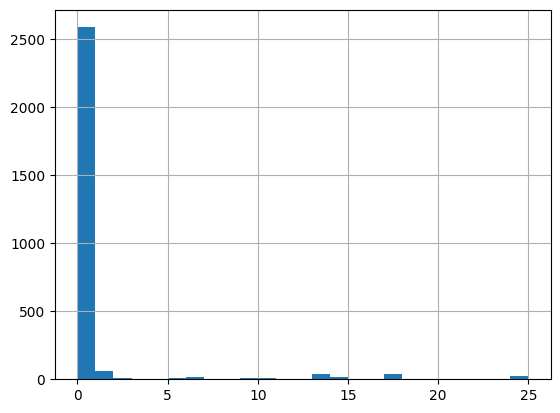

In [8]:
df_union['cover_count'].hist(bins=25)

Выделим следующие группы:
* количество каверов равное 0
* количество каверов от 1 до 5
* количество каверов от 5 до 15
* количество каверов больше 15

In [9]:
df_union.loc[df_union['cover_count']==0, 'group_count_cover'] = 'group_1'
df_union.loc[(df_union['cover_count']>0) &
             (df_union['cover_count']<=5), 'group_count_cover'] = 'group_2'
df_union.loc[(df_union['cover_count']>5) &
             (df_union['cover_count']<=15), 'group_count_cover'] = 'group_3'
df_union.loc[df_union['cover_count']>15, 'group_count_cover'] = 'group_4'

Удалим ненужный столбец cover_count

In [10]:
df_union = df_union.drop('cover_count', axis=1)

Разделим датасет на тренировочную, тестовую и валидационную выборки.

In [11]:
df_train, df_test = train_test_split(df_union,
                                     random_state=RANDOM_STATE,
                                     test_size=0.3,
                                     stratify=df_union['group_count_cover'])

In [12]:
df_train.shape, df_test.shape

((1976, 13), (847, 13))

In [13]:
df_test, df_valid = train_test_split(df_test,
                                     random_state=RANDOM_STATE,
                                     test_size=0.5,
                                     stratify=df_test['group_count_cover'])

In [14]:
df_test.shape, df_valid.shape

((423, 13), (424, 13))

Теперь удалим созданные столбцы и пересоздадим их заново (тренировочная выборка не должна ничего знать о тестовой и валидационной, а для тестовой и валидационной выборки нас будут интересовать количество каверов из трейна). 

In [15]:
df_train = df_train.drop(['cover_list', 'group_count_cover'], axis=1)

Для тестовой и валиадционной выборки удалим только столбец с группами, и найдём пересечение со списком track_id из трейновой выборки

In [16]:
df_test = df_test.drop(['group_count_cover'], axis=1)
df_valid = df_valid.drop(['group_count_cover'], axis=1)

Получим список каверов для трэйна 

In [17]:
df_train = make_covers_column(df_train, False)

Получим множество track_id в трэйновом датасете

In [20]:
set_train_track = set(df_train['track_id'].values)

Найдём пересечения данного множества со списками значений в cover_list

In [23]:
df_test['cover_list'] = df_test.apply(lambda x: list(set(x['cover_list']) & set_train_track), axis=1)
df_valid['cover_list'] = df_valid.apply(lambda x: list(set(x['cover_list']) & set_train_track), axis=1)